**Assignment - Discussion 9.1: Which Cross-Validation Is Best? - Section C**

Using a dataset of your own, explore the data utilizing multiple cross-validation techniques. Choose the most appropriate cross-validation technique for your data.

In your initial post, describe your data, state which cross-validation technique you used, and explain your rationale for deciding on which cross-validation technique was the most appropriate for your specific dataset.

**Submission**

Dataset chosen: https://www.kaggle.com/datasets/juanmerinobermejo/us-sales-cars-dataset/data

Research Question: Which cross-validation technique yields the best model for predicting the sales price of the car based upon Year, Model, Mileage, and New vs Certified status

In [ ]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import root_mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('ggplot')

In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
from sklearn.metrics import root_mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip show google-colab

Name: google-colab
Version: 1.0.0
Summary: Google Colaboratory tools
Home-page: https://colaboratory.research.google.com/
Author: Google Colaboratory team
Author-email: colaboratory-team@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: google-auth, ipykernel, ipython, notebook, pandas, portpicker, requests, tornado
Required-by: 


In [ ]:
!file -i /content/drive/MyDrive/MLAI_Haas/data/cars.csv

/content/drive/MyDrive/MLAI_Haas/data/cars.csv: text/csv; charset=utf-16le


In [ ]:
cars = pd.read_csv('/content/drive/MyDrive/MLAI_Haas/data/cars.csv', encoding='utf-16le')

In [ ]:
cars.head()

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,Mazda,CX-5,2023,New,NaN,NaN,36703.0
1,Kia,Sportage,2023,New,NaN,Classic Kia,28990.0
2,Chevrolet,Camaro,2024,New,NaN,Classic Chevrolet Beaumont,41425.0
3,Ford,Bronco,2023,Used,1551.0,Mike Smith Chrysler Dodge Jeep RAM,58900.0
4,Acura,TLX,2021,Used,30384.0,Mike Smith Nissan,34499.0


In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Brand    144867 non-null  object 
 1   Model    144867 non-null  object 
 2   Year     144867 non-null  int64  
 3   Status   144867 non-null  object 
 4   Mileage  55914 non-null   float64
 5   Dealer   144539 non-null  object 
 6   Price    140956 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 7.7+ MB


In [ ]:
#Drop string features with too many values to encode
cars_clean=cars.drop(['Dealer', 'Model'], axis=1)

In [ ]:
cars.describe()


,Year,Mileage,Price
count,144867.000000,55914.000000,1.409560e+05
mean,2021.374716,52720.606485,5.267889e+04
std,3.995397,44014.784892,4.221504e+04
min,1959.000000,0.000000,1.000000e+00
25%,2021.000000,20116.000000,3.211000e+04
50%,2023.000000,41417.500000,4.707200e+04
75%,2024.000000,73590.750000,6.531125e+04
max,2024.000000,419096.000000,8.078160e+06


DATA CLEANING

In [ ]:
#Identify duplicate data
cars.duplicated().value_counts()

False    139478
True       5389
Name: count, dtype: int64

In [ ]:
#Drop duplicates
cars.drop_duplicates(keep=False, inplace=True)
cars.shape #check results after drop


(135618, 7)

In [ ]:
#Identify missing data
cars.isnull().sum()

Brand          0
Model          0
Year           0
Status         0
Mileage    79866
Dealer       305
Price       1642
dtype: int64

In [ ]:
#Drop missing data
cars_nona=cars_clean.dropna()
cars_nona.shape

(55900, 5)

In [ ]:
#Describe categorical features
categorical = cars_nona.select_dtypes(include=['object']).columns
for column in categorical:
    print(column, cars_nona[column].unique())


Brand ['Ford' 'Acura' 'Volkswagen' 'GMC' 'Infiniti' 'Lexus' 'Toyota' 'Mazda'
 'Honda' 'Lincoln' 'Mercury' 'Cadillac' 'BMW' 'Chevrolet' 'Hyundai'
 'Land Rover' 'Audi' 'Mercedes' 'Jeep' 'Porsche' 'Kia' 'MINI' 'Nissan'
 'Subaru' 'RAM' 'Maserati' 'Tesla' 'Bentley' 'Dodge' 'Mitsubishi' 'FIAT'
 'Rivian' 'Genesis' 'Aston Martin' 'Buick' 'Jaguar' 'Lamborghini' 'Hummer'
 'Saturn' 'Rolls-Royce' 'Volvo' 'Ferrari' 'Polestar' 'Lucid' 'Alfa Romeo'
 'Scion' 'Chrysler' 'Pontiac' 'Karma' 'Smart' 'McLaren' 'Lotus' 'Saab'
 'Maybach' 'Suzuki' 'International Scout' 'Plymouth' 'Geo' 'Isuzu'
 'Oldsmobile' 'Bugatti' 'Eagle']
Status ['Used' 'Certified']


In [ ]:
cars_nona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55900 entries, 3 to 144855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Brand    55900 non-null  object 
 1   Year     55900 non-null  int64  
 2   Status   55900 non-null  object 
 3   Mileage  55900 non-null  float64
 4   Price    55900 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.6+ MB


In [ ]:
#Create dummies for categorical features and add to dataframe
dummies=pd.get_dummies(cars_nona['Status'], dtype=int)
cars_dummies=pd.concat([cars_nona, dummies], axis=1)
cars_dummies.head()

,Brand,Year,Status,Mileage,Price,Certified,Used
3,Ford,2023,Used,1551.0,58900.0,0,1
4,Acura,2021,Used,30384.0,34499.0,0,1
5,Volkswagen,2022,Certified,13895.0,34000.0,1,0
6,GMC,2021,Used,68506.0,56954.0,0,1
16,Infiniti,2019,Used,29009.0,23589.0,0,1


In [ ]:
dummies1=pd.get_dummies(cars_dummies['Brand'], dtype=int)
cars_dummies1=pd.concat([cars_dummies, dummies1], axis=1)
cars_dummies1.head()

,Brand,Year,Status,Mileage,Price,Certified,Used,Acura,Alfa Romeo,Aston Martin,...,Saab,Saturn,Scion,Smart,Subaru,Suzuki,Tesla,Toyota,Volkswagen,Volvo
3,Ford,2023,Used,1551.0,58900.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acura,2021,Used,30384.0,34499.0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Volkswagen,2022,Certified,13895.0,34000.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,GMC,2021,Used,68506.0,56954.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,Infiniti,2019,Used,29009.0,23589.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Drop redundant string features
cars_final=cars_dummies1.drop(['Brand', 'Status'], axis=1)
cars_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55900 entries, 3 to 144855
Data columns (total 67 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 55900 non-null  int64  
 1   Mileage              55900 non-null  float64
 2   Price                55900 non-null  float64
 3   Certified            55900 non-null  int64  
 4   Used                 55900 non-null  int64  
 5   Acura                55900 non-null  int64  
 6   Alfa Romeo           55900 non-null  int64  
 7   Aston Martin         55900 non-null  int64  
 8   Audi                 55900 non-null  int64  
 9   BMW                  55900 non-null  int64  
 10  Bentley              55900 non-null  int64  
 11  Bugatti              55900 non-null  int64  
 12  Buick                55900 non-null  int64  
 13  Cadillac             55900 non-null  int64  
 14  Chevrolet            55900 non-null  int64  
 15  Chrysler             55900 non-null  int

PREP FOR MODELING

In [ ]:
#Define predictor and target features
X = cars_final.drop('Price', axis=1)
y = cars_final['Price']
X.shape

(55900, 66)

In [ ]:
#Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(type(X_train), type(y_train))#



(39130, 66)
(16770, 66)
(39130,)
(16770,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [ ]:
y_train.head()


79944      8325.0
71045     32496.0
83382     46977.0
82788     69562.0
111138    51988.0
Name: Price, dtype: float64

In [ ]:
cars_final.describe()


,Year,Mileage,Price,Certified,Used,Acura,Alfa Romeo,Aston Martin,Audi,BMW,...,Saab,Saturn,Scion,Smart,Subaru,Suzuki,Tesla,Toyota,Volkswagen,Volvo
count,55900.000000,55900.000000,5.590000e+04,55900.000000,55900.000000,55900.000000,55900.000000,55900.000000,55900.000000,55900.000000,...,55900.000000,55900.000000,55900.000000,55900.000000,55900.000000,55900.000000,55900.000000,55900.000000,55900.000000,55900.000000
mean,2018.168945,52724.342326,3.922420e+04,0.136047,0.863953,0.021145,0.002558,0.001020,0.041807,0.061342,...,0.000233,0.000555,0.000930,0.000143,0.017263,0.000107,0.015742,0.115206,0.021413,0.016029
std,4.912262,44017.199366,3.645913e+04,0.342841,0.342841,0.143869,0.050514,0.031916,0.200149,0.239958,...,0.015248,0.023543,0.030486,0.011962,0.130251,0.010360,0.124478,0.319273,0.144759,0.125587
min,1959.000000,0.000000,1.500000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,20116.000000,2.174700e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2020.000000,41419.500000,3.285000e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2021.000000,73592.000000,4.698925e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024.000000,419096.000000,3.399000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: ylabel='Density'>

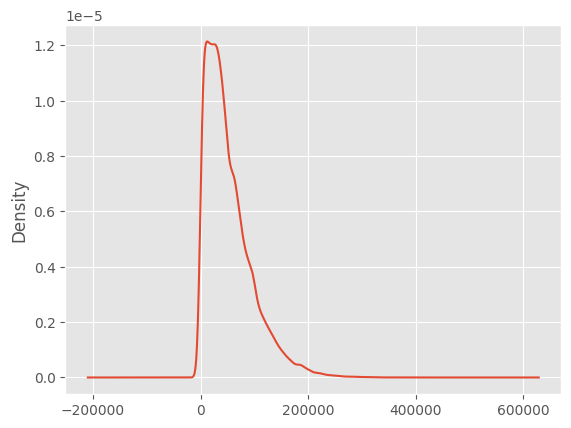

In [ ]:
cars_final['Mileage'].plot(kind = 'kde')

SCALING

In [ ]:
# Scale the data
X_train_scaled = X_train
X_test_scaled = X_test

scale = StandardScaler()
X_train_scaled[:] = scale.fit_transform(X_train[:])
X_test_scaled[:] = scale.transform(X_test[:])

#Check results
X_train_scaled


,Year,Mileage,Certified,Used,Acura,Alfa Romeo,Aston Martin,Audi,BMW,Bentley,...,Saab,Saturn,Scion,Smart,Subaru,Suzuki,Tesla,Toyota,Volkswagen,Volvo
79944,-1.861654,1.976303,-0.396846,0.396846,-0.147663,-0.049333,-0.03278,-0.207551,-0.253914,-0.041415,...,-0.015988,-0.025284,-0.027234,-0.013376,-0.132188,-0.008756,-0.124895,-0.361519,-0.149728,-0.127092
71045,0.372042,0.023072,-0.396846,0.396846,-0.147663,-0.049333,-0.03278,4.818102,-0.253914,-0.041415,...,-0.015988,-0.025284,-0.027234,-0.013376,-0.132188,-0.008756,-0.124895,-0.361519,-0.149728,-0.127092
83382,0.575106,0.135424,-0.396846,0.396846,-0.147663,-0.049333,-0.03278,-0.207551,-0.253914,-0.041415,...,-0.015988,-0.025284,-0.027234,-0.013376,-0.132188,-0.008756,-0.124895,-0.361519,-0.149728,-0.127092
82788,0.575106,-0.906244,-0.396846,0.396846,-0.147663,-0.049333,-0.03278,-0.207551,-0.253914,-0.041415,...,-0.015988,-0.025284,-0.027234,-0.013376,-0.132188,-0.008756,-0.124895,-0.361519,-0.149728,-0.127092
111138,0.372042,-0.393149,2.519868,-2.519868,-0.147663,-0.049333,-0.03278,-0.207551,-0.253914,-0.041415,...,-0.015988,-0.025284,-0.027234,-0.013376,-0.132188,-0.008756,-0.124895,-0.361519,-0.149728,-0.127092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105485,-1.252464,-0.413953,-0.396846,0.396846,-0.147663,-0.049333,-0.03278,-0.207551,-0.253914,-0.041415,...,-0.015988,-0.025284,-0.027234,-0.013376,-0.132188,-0.008756,-0.124895,-0.361519,-0.149728,-0.127092
141693,-0.237148,1.760726,-0.396846,0.396846,-0.147663,-0.049333,-0.03278,-0.207551,-0.253914,-0.041415,...,-0.015988,-0.025284,-0.027234,-0.013376,-0.132188,-0.008756,-0.124895,-0.361519,-0.149728,-0.127092
85133,0.372042,-0.076670,-0.396846,0.396846,-0.147663,-0.049333,-0.03278,-0.207551,-0.253914,-0.041415,...,-0.015988,-0.025284,-0.027234,-0.013376,-0.132188,-0.008756,-0.124895,-0.361519,-0.149728,-0.127092
1650,0.778169,-0.457542,-0.396846,0.396846,-0.147663,-0.049333,-0.03278,-0.207551,-0.253914,-0.041415,...,-0.015988,-0.025284,-0.027234,-0.013376,-0.132188,-0.008756,-0.124895,2.766105,-0.149728,-0.127092


<Axes: ylabel='Density'>

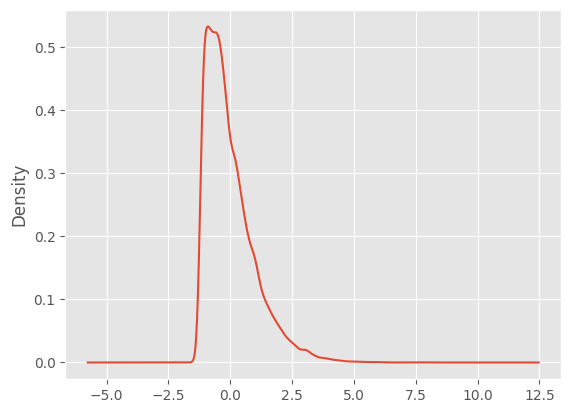

In [ ]:
X_train_scaled['Mileage'].plot(kind = 'kde')

ANALYSIS

In [ ]:
#Build a pipeline with scaling and Ridge regression
pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())]).fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

# Answer check
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 489903509.8041126
Test MSE: 526661272.5246493


In [ ]:
#Select best features for linear regression
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=5)
best_features = selector.fit_transform(X_train_scaled, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())

# ANSWER CHECK
best_features_df.head()


,x1,x10,x18,x33,x52
0,1.976303,-0.005055,-0.039514,-0.040475,-0.176179
1,0.023072,-0.005055,-0.039514,-0.040475,-0.176179
2,0.135424,-0.005055,-0.039514,-0.040475,-0.176179
3,-0.906244,-0.005055,-0.039514,-0.040475,-0.176179
4,-0.393149,-0.005055,-0.039514,-0.040475,-0.176179


1. Simple Cross Validation (Hold Out), 30% of data held out as test set

In [ ]:
#Define and fit the model, predict values for X in training and test sets and calculate MSEs
#Create a timer to log how long each CV technique takes

start_time = time.time()
model = LinearRegression()
model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
end_time = time.time()
time_taken = end_time - start_time

# Answer check
print(f'Time taken: {end_time - start_time}')
print(f'Train MSE: {train_mse: .2f}')
print(f'Test MSE: {test_mse: .2f}')

Time taken: 0.1859419345855713
Train MSE:  489905425.84
Test MSE:  1007230183390283133906138955776.00


2. K-fold Cross Validation

In [ ]:
#Define and fit the model, predict values for X in training and test sets and calculate MSEs
#Create a timer to log how long each CV technique takes

start_time = time.time()
kfold = KFold(n_splits=5, shuffle=True)
kfold_mse_scores = cross_val_score(estimator=model, X=X, y=y, cv=kfold, scoring='neg_mean_squared_error')
end_time = time.time()
time_taken = end_time - start_time

# Answer check
print(f'Time taken: {end_time - start_time}')
print(f'Mean MSE score: {abs(kfold_mse_scores.mean())}')

Time taken: 1.2390227317810059
Mean MSE score: 704223334.3625283


3. Leave One Out

In [ ]:
#Define and fit the model, predict values for X in training and test sets and calculate MSEs
#Create a timer to log how long each CV technique takes

start_time = time.time()
loo_mse_scores = cross_val_score(estimator=model, X=X, y=y, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
end_time = time.time()
time_taken = end_time - start_time

# Answer check
print(f'Time taken: {time_taken}')
print(f'Mean MSE score: {abs(loo_mse_scores.mean())}')


InvalidParameterError: The 'scoring' parameter of cross_val_score must be a str among {'fowlkes_mallows_score', 'max_error', 'neg_root_mean_squared_log_error', 'top_k_accuracy', 'precision_macro', 'jaccard', 'f1', 'jaccard_samples', 'neg_log_loss', 'recall', 'recall_samples', 'f1_weighted', 'positive_likelihood_ratio', 'neg_mean_absolute_error', 'f1_samples', 'mutual_info_score', 'f1_micro', 'normalized_mutual_info_score', 'recall_macro', 'neg_mean_poisson_deviance', 'roc_auc_ovo_weighted', 'roc_auc_ovr_weighted', 'neg_mean_squared_log_error', 'balanced_accuracy', 'precision_samples', 'explained_variance', 'neg_mean_gamma_deviance', 'completeness_score', 'adjusted_rand_score', 'r2', 'adjusted_mutual_info_score', 'neg_mean_absolute_percentage_error', 'recall_micro', 'roc_auc_ovo', 'neg_root_mean_squared_error', 'neg_median_absolute_error', 'f1_macro', 'roc_auc', 'roc_auc_ovr', 'precision_weighted', 'accuracy', 'jaccard_macro', 'neg_brier_score', 'average_precision', 'precision', 'recall_weighted', 'matthews_corrcoef', 'homogeneity_score', 'rand_score', 'v_measure_score', 'jaccard_weighted', 'jaccard_micro', 'neg_negative_likelihood_ratio', 'precision_micro', 'neg_mean_squared_error'}, a callable or None. Got 'mean_squared_error' instead.